(1, 600, 1500, 3)
(1, 1200, 3000, 3)


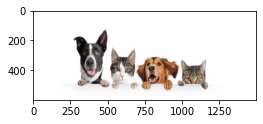

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib
import matplotlib.pyplot as plt

# get data
PATH = '/content/drive/MyDrive/AI Insight/hw 20/template-matching/'
height = 600
width  = 1500
image_path = PATH+'image7.jpg'

scale_level = 2
list_of_images = []

for i in range(scale_level):
  img = kimage.load_img(image_path, target_size=(height*(i+1), width*(i+1)))
  img = np.expand_dims(img, axis=0)
  list_of_images.append(img)

# check
for i in range(scale_level):
  print(list_of_images[i].shape)

plt.figure(figsize=(4,4))
plt.imshow(list_of_images[0][0])

In [ ]:
# get model
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

def compute_features(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

def compute_prediction(data):
  for i in range(19,23):
    data = model.layers[i](data)
  return data

# compute features for templates
list_of_features = []
for i in range(scale_level):
  features = preprocess_input(list_of_images[i])
  print(features.shape)
  features = compute_features(features)
  print(features.shape)
  list_of_features.append(features)

553467904/553467096 [==============================] - 3s 0us/step
(1, 600, 1500, 3)
(1, 18, 46, 512)
(1, 1200, 3000, 3)
(1, 37, 93, 512)


In [ ]:
# compute predictions
side = 7
prediction_data = []

for scale in range(scale_level):
  height_fm = list_of_features[scale].shape[1]
  width_fm  = list_of_features[scale].shape[2]
  depth_fm  = list_of_features[scale].shape[3]
  for i in range(height_fm-side+1):
    for j in range(width_fm-side+1):
      patch = list_of_features[scale][:,i:i+side,j:j+side,:]
      patch = compute_prediction(patch)
      prediction_data.append((tf.math.reduce_max(patch[0]).numpy(), i, j, tf.math.argmax(patch[0]).numpy(), scale))
      
def getKey(item):
    return item[0]

pred_sorted = sorted(prediction_data, key=getKey, reverse=True)
print(pred_sorted[:3])

[(0.9574405, 22, 39, 283, 1), (0.938423, 23, 39, 283, 1), (0.9351347, 24, 38, 283, 1)]


In [ ]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)
print(type(labels))
print(labels[227])

<class 'dict'>
kelpie


In [ ]:
from scipy.spatial import distance

# remove duplication
def check_duplication(i,j,data):
  result = False
  coord1 = (i,j)
  length = len(data)
  for k in range(length):
    coord2 = (data[k][1], data[k][2])
    dst = distance.euclidean(coord1, coord2)
    if (dst < 5):
      result = True
      break
  return result

def remove_duplication(data):
  result = []
  length = len(data)
  for k in range(length-1):
    duplicated = check_duplication(data[k][1], data[k][2], result)
    if (duplicated==False and data[k][0]>0.5):
      result.append(data[k])
  return result

# result = remove_duplication(pred_sorted)
# print(len(result))
# print(result[:3])

In [ ]:
# IOU
def calculate_IOU(boxA, boxB):
    xA = max(boxA[2], boxB[2])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2] + side, boxB[2] + side)
    yB = min(boxA[1] + side, boxB[1] + side)
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
      return 0
    boxAArea = boxBArea = side*side
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def remove_iou(data, threshold):
  result = []
  idxs = list(range(0,len(data)));
  
  while len(idxs) > 0:
    i = idxs[0]
    result.append(data[i])
    idxs =[x for x in idxs if calculate_IOU(data[i],data[x]) < threshold]

  return result

result = remove_iou(pred_sorted, 0.1)
print(len(result))
print(result[:3])

70
[(0.9574405, 22, 39, 283, 1), (0.8178099, 25, 63, 281, 1), (0.8138672, 27, 31, 283, 1)]


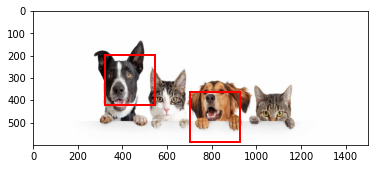

In [ ]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(height, width))
scale_height = height//18
scale_width  = width//46

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
for i in range(length):
  if (result[i][0] > 0.76 and result[i][4]==0):
    rect = patches.Rectangle((result[i][2]*scale_width, result[i][1]*scale_height), 
                             224,224,linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()

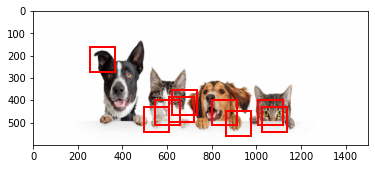

In [ ]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(height, width))
scale_height = height//37
scale_width  = width//93

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
for i in range(length):
  if (result[i][0] > 0.76 and result[i][4]==1):    
    rect = patches.Rectangle((result[i][2]*scale_width, result[i][1]*scale_height), 
                              224//2, 
                              224//2, 
                              linewidth=2, edgecolor='r', 
                              facecolor='none')
    ax.add_patch(rect)
    #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()